# IMPORTS #

In [ ]:
pip install supervision

In [98]:
import torch
import pandas as pd
import numpy as np
from ultralytics.utils.ops import xyxy2xywh
from ultralytics.utils.plotting import Annotator, colors
import cv2
from ultralytics import YOLO
from matplotlib import pyplot as plt
# no longer required
#import fiftyone as fo
#import fiftyone.zoo as foz
import supervision as sv

# Getting the OpenImagesV7 dataset ready for use #

We are going to use the fiftyone lib to get the only the penguin data. \
Then we are going to need to make sure the data is compatible and in the right format for the YOLOv8 model.

## Get only the penguin data from the OpenImagesV7 dataset ##

### Using the fiftyone - this requires the MongaDB so I am going to just work with the dataset directly ###

In [ ]:
# test
# to be removed
dataset = foz.load_zoo_dataset(
    "open-images-v7",
    split="validation",
    max_samples=100,
    seed=51,
    shuffle=True,
)

session = fo.launch_app(dataset.view())
# fiftyone is not working working off the bat so I am going to try something else and come back to this


### working with the dataset and annotations directly ###

data is found here: https://storage.googleapis.com/openimages/web/download_v7.html \
\
The goal is to create a list with all the image ids that specify that a penguin has been detected\
The downloader.py function that is supplied by OIV7 (and is saved it the colab directory) can be called and will only download the images in that list\
We then need to check those images and adjust the relevant annotations to only include those ids and save them.\


In [2]:
# path to the parent folder of the raw data

ROOT_RAW_OI7_PATH = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/OpenImagesV7'

#### Getting the data annotations in a dataframe and filtering to only penguins ####

In [3]:
# load csvs to dataframes to work with
raw_image_labels = pd.read_csv(f'{ROOT_RAW_OI7_PATH}/test-annotations-human-imagelabels-boxable.csv')
raw_bbox_labels = pd.read_csv(f'{ROOT_RAW_OI7_PATH}/test-annotations-bbox.csv')

In [4]:
raw_image_labels.head()

,ImageID,Source,LabelName,Confidence
0,000026e7ee790996,verification,/m/0cgh4,0
1,000026e7ee790996,verification,/m/04hgtk,0
2,000026e7ee790996,verification,/m/0d5gx,0
3,000026e7ee790996,verification,/m/07j7r,1
4,000026e7ee790996,verification,/m/04rky,0


In [5]:
raw_bbox_labels.head()

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside
0,000026e7ee790996,xclick,/m/07j7r,1,0.071875,0.145313,0.206250,0.391667,0,1,1,0,0
1,000026e7ee790996,xclick,/m/07j7r,1,0.439063,0.571875,0.264583,0.435417,0,1,1,0,0
2,000026e7ee790996,xclick,/m/07j7r,1,0.668750,1.000000,0.000000,0.552083,0,1,1,0,0
3,000062a39995e348,xclick,/m/015p6,1,0.206208,0.849224,0.154639,1.000000,0,0,0,0,0
4,000062a39995e348,xclick,/m/05s2s,1,0.137472,0.376940,0.000000,0.883652,1,1,0,0,0


the penguin id (found from the oldv7-class-descriptions-boxable.csv file):\
/m/05z6w

In [6]:
# below you can also just make it image labels where LabelName is the same but the confidence score is also equal to 1
# then you dont need to do the removing the rows thing

In [7]:
# create datasets that only contain entries with images in them
penguin_image_labels = raw_image_labels[raw_image_labels['LabelName'] == '/m/05z6w']
penguin_bbox_labels = raw_bbox_labels[raw_bbox_labels['LabelName'] == '/m/05z6w']

In [8]:
penguin_image_labels.head(97)

,ImageID,Source,LabelName,Confidence
6084,01e8e6894bf88777,verification,/m/05z6w,1
7654,025dfa9ea18bcb18,verification,/m/05z6w,0
14090,045f2a7a01277369,verification,/m/05z6w,0
17172,0555911ee31d049f,verification,/m/05z6w,0
24612,07ca230691eec10e,verification,/m/05z6w,1
...,...,...,...,...
482309,9ee32a851eba0eea,verification,/m/05z6w,1
492643,a25a74a471183cee,verification,/m/05z6w,1
495405,a32f24bc0220911f,verification,/m/05z6w,0
516197,a9ddfcc0e100968c,verification,/m/05z6w,1


In [9]:
# get number of rows (number of images)
penguin_image_labels.shape

(144, 4)

In [10]:
penguin_bbox_labels.head()

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside
7934,01e8e6894bf88777,xclick,/m/05z6w,1,0.050186,0.899628,0.014035,0.843860,0,0,0,0,0
30971,07ca230691eec10e,xclick,/m/05z6w,1,0.000000,0.466814,0.625369,1.000000,1,1,0,0,0
30972,07ca230691eec10e,xclick,/m/05z6w,1,0.327434,0.761062,0.122419,0.501475,1,0,0,0,0
30973,07ca230691eec10e,xclick,/m/05z6w,1,0.396018,0.818584,0.215339,0.971976,0,0,0,0,0
37464,099862b891b82c9a,xclick,/m/05z6w,1,0.526549,0.621681,0.309735,0.401180,0,0,0,1,0


In [11]:
# get number of rows (number of bboxs)
penguin_bbox_labels.shape

(165, 13)

In [12]:
# First I would like to just check that all the ids appear in both lists (sanity check)
# I will remove anything that does not appear in both 
def check_id_presence_in_dfs(df1, df2, id_column, df1_name='df1', df2_name='df2'):
    """
    Check and print IDs that are not present in both dataframes and put them in a list. prints and returns nothing if all ids are present.
    """
    # Set of ids from each df
    ids_df1 = set(df1[id_column])
    ids_df2 = set(df2[id_column])

    # create lists for ids to be removefd
    df1_list_2remove = []
    df2_list_2remove = []

    # Find IDs that are only in df1
    only_in_df1 = ids_df1 - ids_df2
    if only_in_df1:
        #print(f"IDs only in {df1_name}:")
        for id_ in only_in_df1:
            #print(id_)
            df1_list_2remove.append(id_)

    # Find IDs that are only in df2
    only_in_df2 = ids_df2 - ids_df1
    if only_in_df2:
        #print(f"IDs only in {df2_name}:")
        for id_ in only_in_df2:
            #print(id_)
            df2_list_2remove.append(id_)

    return df1_list_2remove, df2_list_2remove

In [13]:
# if returns nothing then all images are present in both dfs
penguin_image_labels_2remove, penguin_bbox_labels_2remove = check_id_presence_in_dfs(penguin_image_labels, penguin_bbox_labels, 'ImageID', 'label', 'bbox')

In [14]:
print(len(penguin_image_labels_2remove))
print(len(penguin_bbox_labels_2remove))

47
0


In [15]:
# function to remove ids that don't appear in both lists
def remove_entries_by_ids(df, id_list, id_column):
    '''Removes rows from the DataFrame where the ID is in the provided list.'''
    filtered_df = df[~df[id_column].isin(id_list)]
    return filtered_df

In [16]:
penguin_image_labels = remove_entries_by_ids(penguin_image_labels, penguin_image_labels_2remove, 'ImageID')
penguin_bbox_labels = remove_entries_by_ids(penguin_bbox_labels, penguin_bbox_labels_2remove, 'ImageID')

In [17]:
penguin_image_labels.shape

(97, 4)

In [18]:
penguin_bbox_labels.shape

(165, 13)

#### creating the text file with a list of all the images the contain penguins and getting all the images from that and downloading those images to a folder - you only need to do this once for the test, train and val datasets on the ####

In [19]:
# create a text file with the following layout:
#$SPLIT/$IMAGE_ID, where $SPLIT is either "train", "test", "validation", or "challenge2018"; and $IMAGE_ID is the image ID that uniquely identifies the image
# so the text file will look like this:
#train/f9e0434389a1d4dd
#train/1a007563ebc18664
#test/ea8bfd4e765304db
# the following function should create the required text file:
def write_ids_to_file(location, name, df):
    """
    Writes entries to a text file where each entry is 'name/id' from the DataFrame's ID column.

    :param location: String, the directory where the text file will be saved.
    :param name: String, the name to be prefixed before each ID.
    :param df: DataFrame, the dataframe containing an 'id' column.
    """
    # Open a file at the specified location to write
    with open(f"{location}/{name}_ids.txt", "w") as file:
        # Loop through each id in the DataFrame
        for id_ in df['ImageID']:
            # Write formatted string to file
            file.write(f"{name}/{id_}\n")

In [11]:
# call the above function for the test images
# call the above function for the test images
# call the above function for the test images
write_ids_to_file(ROOT_RAW_OI7_PATH, 'test', penguin_image_labels)

Now run the following command in the terminal:\
python3 /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/notebooks/OpenImagesV7_downloader.py /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/OpenImagesV7/image_list_file.txt --download_folder=/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/OpenImagesV7/OpenImageV7_raw_images --num_processes=5

but replace image_list_file.txt with the name of the test file you just created.\
\
The images should be copied to the /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/OpenImagesV7/OpenImageV7_raw_images directory 

In [19]:
# this will allow you to see the row corresponding to the id provided
input_id = '0d6a527e509d7e6e'
matching_row = penguin_image_labels[penguin_image_labels['ImageID'] == input_id]
print(matching_row)

Empty DataFrame
Columns: [ImageID, Source, LabelName, Confidence]
Index: []


In [18]:
# this will allow you to see the row corresponding to the id provided
input_id = '0d6a527e509d7e6e'
matching_row = penguin_bbox_labels[penguin_bbox_labels['ImageID'] == input_id]
print(matching_row)

Empty DataFrame
Columns: [ImageID, Source, LabelName, Confidence, XMin, XMax, YMin, YMax, IsOccluded, IsTruncated, IsGroupOf, IsDepiction, IsInside]
Index: []


#### Create the annotation files ####
here we need to create a text file for each image with the following format for each bounding box in that image, where each bounding box is on a new line:\
0 x_centre_value y_centre_value width height \
\
note that all values are normalised between zero and 1

##### convert the bboxs to Yolo format: XCentre YCentre Width Height and save these as new columns to the df and save that dataframe to a .json file - might need to convert it to a series first

In [19]:
# first we need to create a function to get bounding boxes in an array in a format:
# x1 y1 x2 y2
# since the origin is in the top left corner, that is to say it must be:
# XMin Ymin XMax YMax
# test
def extract_values_to_array(df, column_names):
    """
    Extracts values from specified columns in a DataFrame and returns them as a numpy array.
    
    :param df: pandas DataFrame from which to extract values.
    :param column_names: List of column names whose values are to be extracted.
    :return: A numpy array with each row corresponding to the values from the specified columns in the DataFrame.
    """ 
    # Extract the values as a numpy array
    array_values = df[column_names].to_numpy()
    
    return array_values


In [20]:
# use the above function to obtain the desired array
list_col_to_extract = ['XMin', 'YMin', 'XMax', 'YMax']

penguin_bbox_labels_arr = extract_values_to_array(penguin_bbox_labels,list_col_to_extract)

print(penguin_bbox_labels_arr[0:10])

[[   0.050186    0.014035     0.89963     0.84386]
 [          0     0.62537     0.46681           1]
 [    0.32743     0.12242     0.76106     0.50147]
 [    0.39602     0.21534     0.81858     0.97198]
 [    0.52655     0.30973     0.62168     0.40118]
 [    0.56416     0.29941      0.6792     0.40118]
 [   0.024427     0.34188     0.20458     0.75427]
 [    0.24427     0.27564     0.44733     0.75641]
 [    0.46565        0.25     0.60153     0.63034]
 [    0.80611     0.41239           1     0.72436]]


In [21]:
print(penguin_bbox_labels.iloc[1])
# checking the output of the arrayh and it looks good

ImageID        07ca230691eec10e
Source                   xclick
LabelName              /m/05z6w
Confidence                    1
XMin                        0.0
XMax                   0.466814
YMin                   0.625369
YMax                        1.0
IsOccluded                    1
IsTruncated                   1
IsGroupOf                     0
IsDepiction                   0
IsInside                      0
Name: 30971, dtype: object


In [22]:
# using the function from Yolo to convert from xyxy to xywh
penguin_bbox_labels_arr_xywh = xyxy2xywh(penguin_bbox_labels_arr)

In [23]:
print(penguin_bbox_labels_arr_xywh[0:10])

[[    0.47491     0.42895     0.84944     0.82982]
 [    0.23341     0.81268     0.46681     0.37463]
 [    0.54425     0.31195     0.43363     0.37906]
 [     0.6073     0.59366     0.42257     0.75664]
 [    0.57412     0.35546    0.095133    0.091445]
 [    0.62168     0.35029     0.11504     0.10177]
 [     0.1145     0.54808     0.18015     0.41239]
 [     0.3458     0.51603     0.20305     0.48077]
 [    0.53359     0.44017     0.13588     0.38034]
 [    0.90305     0.56838     0.19389     0.31197]]


In [24]:
# check the first entry is correct
# check centre x 
print(((penguin_bbox_labels_arr[0, 2] - penguin_bbox_labels_arr[0, 0])/2)+penguin_bbox_labels_arr[0, 0])
# check centre y 
print(((penguin_bbox_labels_arr[0, 3] - penguin_bbox_labels_arr[0, 1])/2)+penguin_bbox_labels_arr[0, 1])
# check centre w 
print((penguin_bbox_labels_arr[0, 2] - penguin_bbox_labels_arr[0, 0]))
# check centre h
print((penguin_bbox_labels_arr[0, 3] - penguin_bbox_labels_arr[0, 1]))

0.47490708700000006
0.428947394
0.8494424260000001
0.829824612


In [33]:
# convert arr to df and specify the column names
new_cols = ['XCentre', 'YCentre', 'Width', 'Height']
penguin_bbox_labels_arr_xywh_df = pd.DataFrame(penguin_bbox_labels_arr_xywh, columns=new_cols, index=penguin_bbox_labels.index)

In [34]:
penguin_bbox_labels_arr_xywh_df.head()

,XCentre,YCentre,Width,Height
7934,0.474907,0.428947,0.849442,0.829825
30971,0.233407,0.812684,0.466814,0.374631
30972,0.544248,0.311947,0.433628,0.379056
30973,0.607301,0.593658,0.422566,0.756637
37464,0.574115,0.355457,0.095133,0.091445


In [35]:
penguin_bbox_labels.shape

(165, 13)

In [36]:
penguin_bbox_labels_arr_xywh_df.shape

(165, 4)

In [37]:
# concat new df to the end of the original df
penguin_bbox_labels_xywh = pd.concat([penguin_bbox_labels, penguin_bbox_labels_arr_xywh_df], axis=1)

In [39]:
penguin_bbox_labels_xywh.head()

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside,XCentre,YCentre,Width,Height
7934,01e8e6894bf88777,xclick,/m/05z6w,1,0.050186,0.899628,0.014035,0.843860,0,0,0,0,0,0.474907,0.428947,0.849442,0.829825
30971,07ca230691eec10e,xclick,/m/05z6w,1,0.000000,0.466814,0.625369,1.000000,1,1,0,0,0,0.233407,0.812684,0.466814,0.374631
30972,07ca230691eec10e,xclick,/m/05z6w,1,0.327434,0.761062,0.122419,0.501475,1,0,0,0,0,0.544248,0.311947,0.433628,0.379056
30973,07ca230691eec10e,xclick,/m/05z6w,1,0.396018,0.818584,0.215339,0.971976,0,0,0,0,0,0.607301,0.593658,0.422566,0.756637
37464,099862b891b82c9a,xclick,/m/05z6w,1,0.526549,0.621681,0.309735,0.401180,0,0,0,1,0,0.574115,0.355457,0.095133,0.091445


In [41]:
penguin_bbox_labels_xywh.shape

(165, 17)

In [42]:
# now save it as a .json file so we dont have to do this again
# we will use the orient = 'records' as this is the default and
# the most common
json_path_parent = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/OpenImagesV7'
json_path = f'{json_path_parent}/test_full_annotation.json'

penguin_bbox_labels_xywh.to_json(json_path, orient='records')

##### Run the below to load the full annotations to a df #####

In [ ]:
# the following code will read a .json file to a df
# just uncomment and run the code below changing the name of the json file
# json_path = ''/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/OpenImagesV7/test_full_annotation.json'
# df = pd.read_json_into_df(json_path, orient='records')

##### step through the df and create a text file for each unique instance of an image id then add: 0 XCentre YCentre Width Height as a new line for each bounding box for a specific image id #####

In [59]:
# create a function 
def df_to_YOLO_txt_file(df, txt_file_path_parent):
    # step through the df
    for index, entry in df.iterrows():
        # get info from entry
        ImageID = entry['ImageID']
        XCentre = entry['XCentre']
        YCentre = entry['YCentre']
        Width = entry['Width']
        Height = entry['Height']

        txt_file_path = f'{txt_file_path_parent}/{ImageID}.txt'

        # write info to text file in desired format
        with open(txt_file_path, 'a') as file:
            file.write(f'0 {XCentre} {YCentre} {Width} {Height}\n')


In [61]:
# before running the below you need to check the number of files
# in the destination folder so you can see that the correct number of 
# txt files have been made (should = number of penguin_image_label)
penguin_image_labels.shape

(97, 4)

In [60]:
txt_file_path_parent = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/OpenImagesV7/OI7_Yolo_annotations'
df_to_YOLO_txt_file(penguin_bbox_labels_xywh, txt_file_path_parent)

In [ ]:
# now check the number of files in the folder (just use file explorer)

#### View the results to check they are correct ####

##### attempt to use supervision #####

In [91]:
image = cv.imread('/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/OpenImagesV7/OpenImageV7_raw_images/3df173193a2bac8b.jpg')
ann = Annotator(image)
txt_path = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/OpenImagesV7/OI7_Yolo_annotations/3df173193a2bac8b.txt'
bbox_arr = np.loadtxt(txt_path, dtype=np.float16, delimiter=' ', usecols=(1,2,3,4))
bbox_tensor = torch.from_numpy(bbox_arr)
bbox_dict = {'predictions': tuple(row[:]) for row in bbox_arr}

In [92]:
print(bbox_arr)
print(bbox_tensor)
print(bbox_dict)

[[    0.40332     0.75977    0.051636     0.16589]
 [    0.51172     0.79297    0.097351     0.16589]
 [    0.58545     0.77637    0.061951     0.15491]]
tensor([[0.4033, 0.7598, 0.0516, 0.1659],
        [0.5117, 0.7930, 0.0974, 0.1659],
        [0.5854, 0.7764, 0.0620, 0.1549]], dtype=torch.float16)
{'predictions': (0.5854, 0.7764, 0.06195, 0.1549)}


In [93]:
detect1 = sv.Detections.from_inference(bbox_dict)

KeyError: 'image'

In [82]:
box_annotator = sv.BoundingBoxAnnotator()
annotated_frame = box_annotator.annotate(image.copy(), detections=bbox_tensor)
sv.plot_image(image=annotated_frame, size=(16, 16))

AttributeError: 'Tensor' object has no attribute 'xyxy'

##### Attempt to use cv #####

In [94]:
# display images inline
%matplotlib inline

In [103]:
image_path = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/OpenImagesV7/OpenImageV7_raw_images/3df173193a2bac8b.jpg'
txt_path = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/OpenImagesV7/OI7_Yolo_annotations/3df173193a2bac8b.txt'
bbox_arr = np.loadtxt(txt_path, dtype=np.float16, delimiter=' ', usecols=(1,2,3,4))

In [104]:
print(bbox_arr)

[[    0.40332     0.75977    0.051636     0.16589]
 [    0.51172     0.79297    0.097351     0.16589]
 [    0.58545     0.77637    0.061951     0.15491]]


In [119]:
def draw_bboxes_and_show(image_path, bboxes):
    """
    Draws bounding boxes on an image and displays it inline in a Jupyter Notebook.

    :param image_path: Path to the image file.
    :param bboxes: NumPy array of bbox in the format [x_center, y_center, width, height] as normalized values.
    """
    # Load the image
    img = cv2.imread(image_path)
    
    # Ensure the image was loaded
    if img is None:
        print("Image not loaded; please check the path.")
        return
    
    # Convert bounding box coordinates from normalized to absolute pixel values
    height, width = img.shape[:2]
    #print(height, width)
    scaled_bboxes = np.zeros_like(bboxes) # creating emptry array of correct size
    #print(scaled_bboxes)
    scaled_bboxes[:, 0] = (bboxes[:, 0] - (bboxes[:, 2] / 2))* width   # x_min
    scaled_bboxes[:, 1] = (bboxes[:, 1] - bboxes[:, 3] / 2)* height  # y_min
    scaled_bboxes[:, 2] = (bboxes[:, 0] + bboxes[:, 2] / 2)* width   # x_max
    scaled_bboxes[:, 3] = (bboxes[:, 1] + bboxes[:, 3] / 2)* height  # y_max
    
    #print(scaled_bboxes)
    # Draw each bounding box on the image
    for (x_min, y_min, x_max, y_max) in scaled_bboxes:
        cv2.rectangle(img, (int(x_min), int(y_min)), (int(x_max), int(y_max)), (255, 0, 0), 2)
    
    # Convert BGR image to RGB
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Display the image
    plt.figure(figsize=(10, 10))
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.show()

[[    0.40332     0.75977    0.051636     0.16589]
 [    0.51172     0.79297    0.097351     0.16589]
 [    0.58545     0.77637    0.061951     0.15491]]


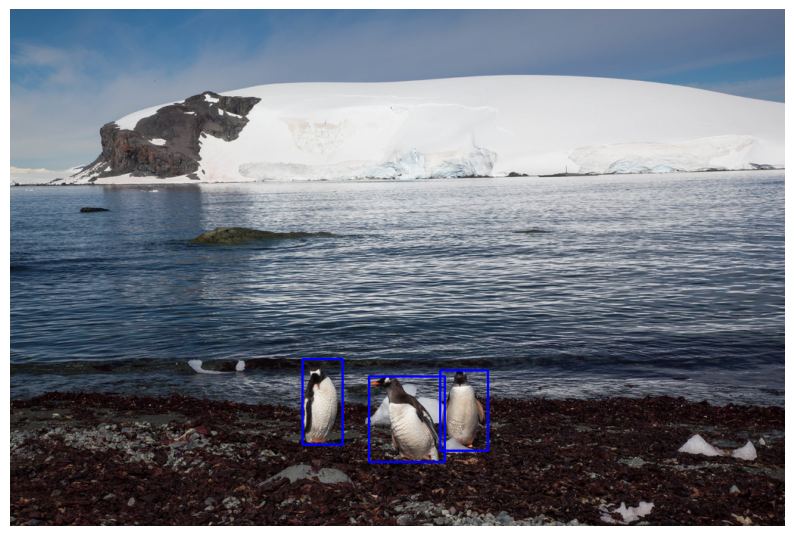

In [120]:
#print(bbox_arr)
draw_bboxes_and_show(image_path, bbox_arr)